## NN_Handler example

This notebook is a simple example of how to use the `NNHandler` handler class of `nn_handler.py`. A simple model for the MNIST dataset will be trained.

In [1]:
import logging

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from src.nn_handler.nn_handler_distributed import NNHandler

## 1. Define a NN architecture
Define a neural network architecture extending the `nn.Module` base class. 

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## 2. Get training and validation (optional) datasets

In this case, the MNIST datasets will be used.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

training_data = datasets.MNIST(root='./data', train=True, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))

test_data = datasets.MNIST(root='./data', train=False, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ]))


## 3. Initialize or load the NNHandler

When loaded, the handler is in the same state as when the instance was saved, minus the logging. If needed, it can be initialized with the `model.initialize_logger` method.

In [4]:
model = NNHandler.initialize(model_class=Net, device=device, optimizer_class=optim.Adamax,
                             loss_fn=nn.functional.nll_loss, train_data=training_data, val_data=test_data,
                             optimizer_kwargs={"lr": 0.01},
                             train_loader_kwargs={"batch_size": 1024, "shuffle": True},
                             val_loader_kwargs={"batch_size": 1000, "shuffle": True},
                             auto_save_interval=1, auto_save_path="models", auto_save_overwrite=True, 
                             logger_mode=NNHandler.LoggingMode.FILE,
                             logger_filename="models/training.log",
                             logger_level=logging.INFO, save_model_code=False)

INFO: No DDP environment detected and use_distributed=None. Running non-DDP.


/tmp/ipykernel_4665/3621475080.py:1: DeprecationWarning: NNHandler.initialize is deprecated. Use direct __init__ and setters.
  model = NNHandler.initialize(model_class=Net, device=device, optimizer_class=optim.Adamax,


## 4. Train the model

In [5]:
model.train(5, validate_every=1)

Epochs:   0%|          | 0/5 [00:00<?, ?epoch/s]

## 5. Load the model

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NNHandler.load("models/model_state_epoch_5.pth", device)

## 6. Plot results

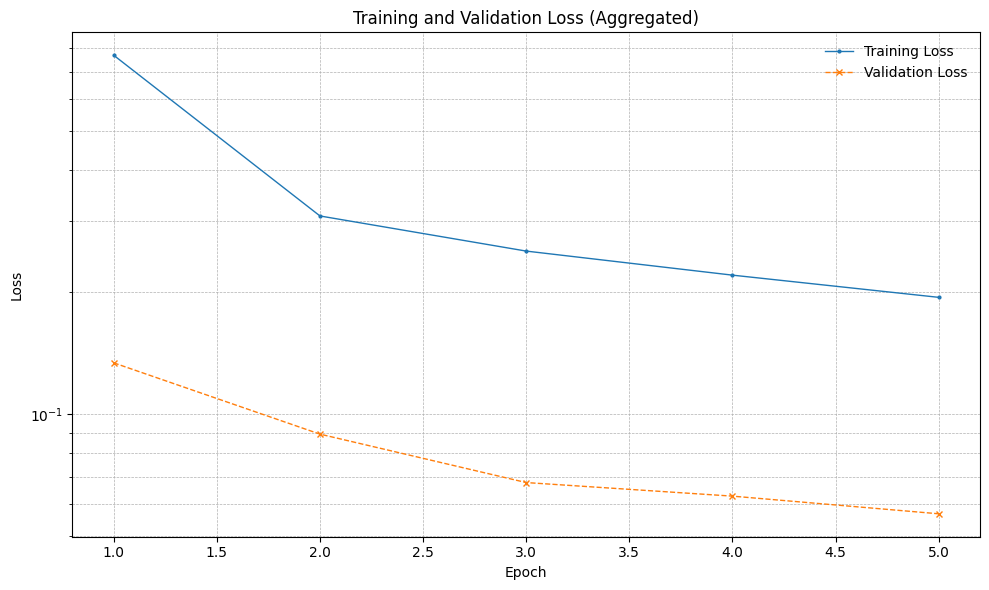

In [6]:
model.plot_losses(True)

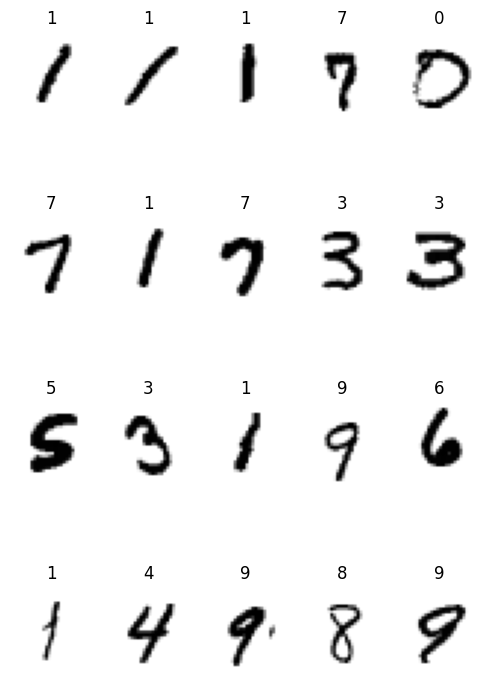

In [7]:
from matplotlib import pyplot as plt

# Plot n samples from the validation dataset with their predictions
n = 20
test_loader = torch.utils.data.DataLoader(test_data, batch_size=n, shuffle=True)
data_iter = iter(test_loader)
images, labels = data_iter.__next__()

# Get predictions
model.eval()
with torch.no_grad():
    images = images.to(device)
    outputs = model(images)

_, predicted = torch.max(outputs, 1)

plt.figure(figsize=(5, n // 5 * 2))
for index in range(n):
    plt.subplot(n // 5, 5, index + 1)
    plt.axis('off')
    plt.imshow(images[index].cpu().numpy().squeeze(), cmap='gray_r')
    plt.title('%i' % predicted[index])

plt.tight_layout()


In [18]:
model.model_code